# Anomalia bouguer para os Andes

## Importando bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import verde as vd
import pyproj
import boule as bl
import harmonica as hm

In [2]:
notebook_name = '5.Andes_bouguer_anomaly.ipynb'

### Plot style

In [3]:
plt.style.use('ggplot')

### Carregando os dados

In [4]:
fname = 'data_set/gravity_002deg_Andes_EIGEN-6C4.gdf'

In [5]:
data = hm.load_icgem_gdf(fname)

In [6]:
fname = 'data_set/geoid_002deg_Andes_EIGEN-6C4.gdf'

In [7]:
geoide = hm.load_icgem_gdf(fname)

In [8]:
data['geoid'] = geoide.geoid

In [9]:
fname = 'data_set/topography_002deg_Andes_etopo1.gdf'

In [10]:
topografia = hm.load_icgem_gdf(fname) 

In [11]:
data['topography'] = topografia.topography_shm

### Informações sobre a região e os dados

In [12]:
region = (-80,-50,-35,-15)

### Cálculo da gravidade normal

In [13]:
elipsoide = bl.WGS84

In [14]:
data['gamma'] = elipsoide.normal_gravity(data.latitude,data.h_over_geoid)

### Cálculo do distúrbio

In [15]:
data['disturbance'] = data.gravity_earth - data.gamma

### Cálculo da anomalia bouguer 

In [16]:
data['h_over_ell'] = data.geoid + data.topography
bouguer = hm.bouguer_correction(data.h_over_ell)
data['disturbance_bouguer'] = data.disturbance - bouguer

## Campo de gravidade, gravidade normal e distúrbio

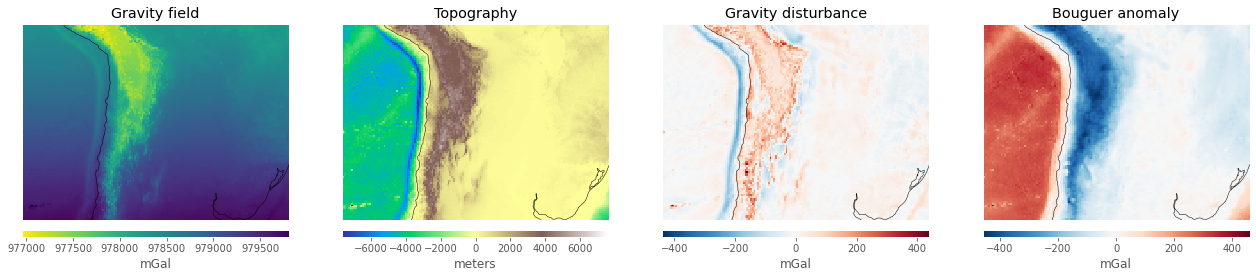

In [17]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(nrows=1,ncols=4,figsize=(22, 18), subplot_kw=dict(projection=ccrs.Mercator()))

pg = data.gravity_earth.plot.pcolormesh(ax=ax1, cmap="viridis_r", add_colorbar=False, transform=ccrs.PlateCarree())
plt.colorbar(pg, ax=ax1, orientation="horizontal", pad=0.01, aspect=40, label="mGal")
ax1.coastlines()
ax1.set_title("Gravity field")
ax1.set_extent(region,crs=ccrs.PlateCarree())

pn = data.h_over_ell.plot.pcolormesh(ax=ax2, cmap="terrain", add_colorbar=False, transform=ccrs.PlateCarree())
plt.colorbar(pn, ax=ax2, orientation="horizontal", pad=0.01, aspect=40, label="meters")
ax2.coastlines()
ax2.set_title("Topography")
ax2.set_extent(region,crs=ccrs.PlateCarree())

pd = data.disturbance.plot.pcolormesh(ax=ax3, cmap="RdBu_r", add_colorbar=False, transform=ccrs.PlateCarree())
plt.colorbar(pd, ax=ax3, orientation="horizontal", pad=0.01, aspect=40, label="mGal")
ax3.coastlines()
ax3.set_title("Gravity disturbance")
ax3.set_extent(region,crs=ccrs.PlateCarree())

pb = data.disturbance_bouguer.plot.pcolormesh(ax=ax4, cmap="RdBu_r", add_colorbar=False, transform=ccrs.PlateCarree())
plt.colorbar(pb, ax=ax4, orientation="horizontal", pad=0.01, aspect=40, label="mGal")
ax4.coastlines()
ax4.set_title("Bouguer anomaly")
ax4.set_extent(region,crs=ccrs.PlateCarree())

plt.show()

## Visualização dos dados em um perfil

### Definindo as coordenadas em um grid regular

In [18]:
spacing = 0.2

In [19]:
longitude = np.arange(region[0],region[1]+spacing,step=spacing)
latitude = np.arange(region[2],region[3]+spacing,step=spacing)

In [20]:
long,lat = np.meshgrid(longitude,latitude)

In [21]:
full_coordinates = (long,lat)

### Decimando os dados de distúrbio

In [22]:
spacing = 12/ 60
reducer = vd.BlockReduce(reduction=np.median, spacing=spacing)
coordinates, disturbance = reducer.filter(
    (long,lat), data.disturbance.values)

In [23]:
projection = pyproj.Proj(proj="merc", lat_ts=coordinates[1].mean())
proj_coords = projection(*coordinates)

### Interpolação dos dados sobre os perfis

In [24]:
spline = vd.Spline(damping=9*1e-8)

In [25]:
start = (-77,-23)
end = (-62,-23)

#### Perfil do distúrbio

In [26]:
interpolate_dist = spline.fit(proj_coords,disturbance)

In [27]:
profile_dist = interpolate_dist.profile(
    point1=start,
    point2=end, 
    size=400, 
    dims=("latitude","longitude"),
    data_names=["disturbance"],
    projection=projection,)

In [28]:
profile_dist

,latitude,longitude,distance,disturbance
0,-23.0,-77.000000,0.000000e+00,-9.008324
1,-23.0,-76.962406,3.797633e+03,-8.660386
2,-23.0,-76.924812,7.595265e+03,-8.233890
3,-23.0,-76.887218,1.139290e+04,-7.741458
4,-23.0,-76.849624,1.519053e+04,-7.192829
...,...,...,...,...
395,-23.0,-62.150376,1.500065e+06,9.980678
396,-23.0,-62.112782,1.503863e+06,10.716588
397,-23.0,-62.075188,1.507660e+06,11.377738
398,-23.0,-62.037594,1.511458e+06,11.959528


### Decimando os dados de topografia

In [29]:
spacing = 12/ 60
reducer = vd.BlockReduce(reduction=np.median, spacing=spacing)
coordinates, topography = reducer.filter(
    (long,lat), data.h_over_ell.values)

In [30]:
interpolate_topo = spline.fit(proj_coords,topography)

#### Perfil dos dados de topografia

In [31]:
profile_topo = interpolate_topo.profile(
    point1=start,
    point2=end, 
    size=400, 
    dims=("latitude","longitude"),
    data_names=["topography"],
    projection=projection,)

In [32]:
profile_topo

,latitude,longitude,distance,topography
0,-23.0,-77.000000,0.000000e+00,-4629.432842
1,-23.0,-76.962406,3.797633e+03,-4623.037011
2,-23.0,-76.924812,7.595265e+03,-4615.727722
3,-23.0,-76.887218,1.139290e+04,-4607.694381
4,-23.0,-76.849624,1.519053e+04,-4599.097360
...,...,...,...,...
395,-23.0,-62.150376,1.500065e+06,238.933837
396,-23.0,-62.112782,1.503863e+06,237.543273
397,-23.0,-62.075188,1.507660e+06,236.100526
398,-23.0,-62.037594,1.511458e+06,234.613422


### Decimando os dados de anomalia bouguer

In [33]:
spacing = 12/ 60
reducer = vd.BlockReduce(reduction=np.median, spacing=spacing)
coordinates, bouguer_topo = reducer.filter(
    (long,lat), data.disturbance_bouguer.values)

In [34]:
interpolate_bouguer = spline.fit(proj_coords,bouguer_topo)

In [35]:
profile_bouguer = interpolate_bouguer.profile(
    point1=start,
    point2=end, 
    size=400, 
    dims=("latitude","longitude"),
    data_names=["bouguer"],
    projection=projection,)

In [36]:
profile_bouguer

,latitude,longitude,distance,bouguer
0,-23.0,-77.000000,0.000000e+00,307.489856
1,-23.0,-76.962406,3.797633e+03,307.389500
2,-23.0,-76.924812,7.595265e+03,307.305825
3,-23.0,-76.887218,1.139290e+04,307.239186
4,-23.0,-76.849624,1.519053e+04,307.190824
...,...,...,...,...
395,-23.0,-62.150376,1.500065e+06,-16.777648
396,-23.0,-62.112782,1.503863e+06,-15.882892
397,-23.0,-62.075188,1.507660e+06,-15.056802
398,-23.0,-62.037594,1.511458e+06,-14.304932


## Visualização dos perfis

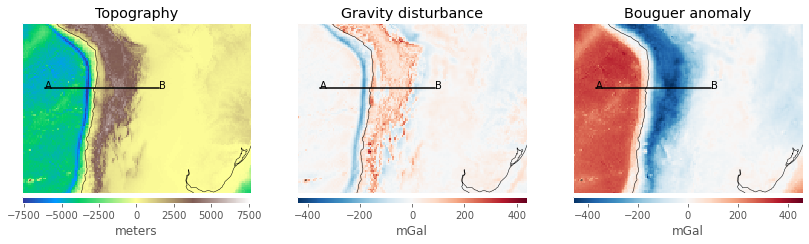

In [37]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(14, 8), subplot_kw=dict(projection=ccrs.Mercator()))

pn = data.h_over_ell.plot.pcolormesh(ax=ax1, cmap="terrain", add_colorbar=False, transform=ccrs.PlateCarree())
plt.colorbar(pn, ax=ax1, orientation="horizontal", pad=0.01, aspect=40, label="meters")
ax1.plot(profile_topo.longitude, profile_topo.latitude, "-k", transform=ccrs.PlateCarree())
ax1.text(start[0], start[1], "A", transform=ccrs.PlateCarree())
ax1.text(end[0], end[1], "B", transform=ccrs.PlateCarree())
ax1.coastlines()
ax1.set_title("Topography")
ax1.set_extent(region,crs=ccrs.PlateCarree())

pd = data.disturbance.plot.pcolormesh(ax=ax2, cmap="RdBu_r", add_colorbar=False, transform=ccrs.PlateCarree())
plt.colorbar(pd, ax=ax2, orientation="horizontal", pad=0.01, aspect=40, label="mGal")
ax2.plot(profile_dist.longitude, profile_dist.latitude, "-k", transform=ccrs.PlateCarree())
ax2.text(start[0], start[1], "A", transform=ccrs.PlateCarree())
ax2.text(end[0], end[1], "B", transform=ccrs.PlateCarree())
ax2.coastlines()
ax2.set_title("Gravity disturbance")
ax2.set_extent(region,crs=ccrs.PlateCarree())

pb = data.disturbance_bouguer.plot.pcolormesh(ax=ax3, cmap="RdBu_r", add_colorbar=False, transform=ccrs.PlateCarree())
plt.colorbar(pb, ax=ax3, orientation="horizontal", pad=0.01, aspect=40, label="mGal")
ax3.plot(profile_bouguer.longitude, profile_bouguer.latitude, "-k", transform=ccrs.PlateCarree())
ax3.text(start[0], start[1], "A", transform=ccrs.PlateCarree())
ax3.text(end[0], end[1], "B", transform=ccrs.PlateCarree())
ax3.coastlines()
ax3.set_title("Bouguer anomaly")
ax3.set_extent(region,crs=ccrs.PlateCarree())

plt.show()

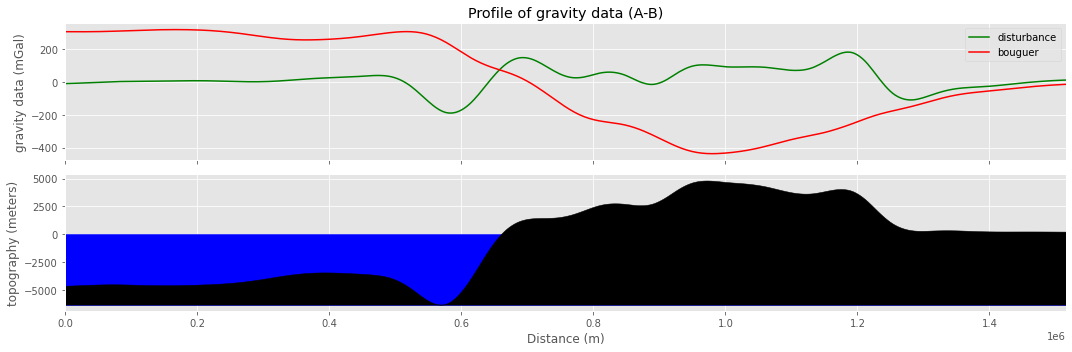

In [38]:
fig,(ax1,ax2) = plt.subplots(nrows=2, ncols=1, sharex=True,figsize=(15, 5))

### Disturbio e anomalia bouguer (com a topografia)
ax1.set_title("Profile of gravity data (A-B)")
ax1.plot(profile_dist.distance, profile_dist.disturbance, "-g",label='disturbance')
ax1.plot(profile_bouguer.distance, profile_bouguer.bouguer, "-r",label='bouguer')
ax1.set_ylabel("gravity data (mGal)")
ax1.set_xlim(profile_dist.distance.min(), profile_dist.distance.max())
ax1.legend()

### Topografia e o nível do mar
ax2.fill_between(profile_topo.distance,0.,min(profile_topo.topography),color='blue')
ax2.fill_between(profile_topo.distance,profile_topo.topography,min(profile_topo.topography),color='black')
ax2.set_ylabel("topography (meters)")
ax2.set_xlim(profile_topo.distance.min(), profile_topo.distance.max())
ax2.set_xlabel("Distance (m)")

plt.tight_layout()
plt.show()